<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

In [1]:
import pandas as pd
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import train_test_split, HalvingGridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

plt.style.use('seaborn-whitegrid')

## Подготовка данных

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [3]:
RANDOM_STATE = 12345

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* **Заполним пропуски используя метод k-ближайших соседей**

In [6]:
#Разделим исходные данные на признаки и целевой признак, причем модель будем строить и тестировать на данных без пропусков.
#В нашем случае целевым на данном этапе является 'Tenure'
features_df_without_nan = df[~df['Tenure'].isnull()][['CreditScore', 'Geography','Gender', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard',
                                          'IsActiveMember', 'EstimatedSalary']]
target_df_without_nan = df[~df['Tenure'].isnull()]['Tenure']

features_df_with_nan = df[df['Tenure'].isnull()][['CreditScore', 'Geography','Gender', 'Age', 'Balance', 'NumOfProducts', 'HasCrCard',
                                          'IsActiveMember', 'EstimatedSalary']]
target_with_nan = df[df['Tenure'].isnull()]['Tenure']

In [7]:
#Разделим данные на обучающую и валидационую выборки (на данном этапе делим только на 2 выборки для заполнения пропусков)
features_train, features_valid, target_train, target_valid = train_test_split(features_df_without_nan, target_df_without_nan,
                                                              test_size=0.25, random_state=RANDOM_STATE)

In [8]:
import warnings
warnings.filterwarnings('ignore')
#Применим OHE чтобы избавится от категориальных переменных
cat = ['Geography','Gender']
enc = OneHotEncoder(drop='first', sparse=False)
enc.fit(features_train[cat])

features_train[enc.get_feature_names()] = enc.transform(features_train[cat])
features_train = features_train.select_dtypes(exclude=['object'])

features_valid[enc.get_feature_names()] = enc.transform(features_valid[cat])
features_valid = features_valid.select_dtypes(exclude=['object'])

features_df_with_nan[enc.get_feature_names()] = enc.transform(features_df_with_nan[cat])
features_df_with_nan = features_df_with_nan.select_dtypes(exclude=['object'])

In [9]:
numeric = [col for col in features_train.columns if (features_train[col].dtype != 'object') & (col not in ['HasCrCard', 'IsActiveMember'] )]
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [10]:
#Используя HalvingGridSearchCV подберем наилучшие гиперпараметры для KNN модели
warnings.filterwarnings('ignore')

parameters = {'n_neighbors': range (1, 50, 10)}
model = KNeighborsClassifier()
grid = HalvingGridSearchCV(model, parameters, random_state=RANDOM_STATE, scoring ='accuracy').fit(features_train, target_train)
best_model_knn = grid.best_estimator_
print(f'Точность наилучшей модели на валидационной выборке: {grid.best_score_:.2f} \
      \nГиперпараметры: {grid.best_params_}')

Точность наилучшей модели на валидационной выборке: 0.10       
Гиперпараметры: {'n_neighbors': 31}


In [11]:
#Протестирум модель на валидацонной выборке
best_model_knn.score(features_valid, target_valid)

0.09370875494940607

In [12]:
parameters = {'n_estimators': range (1, 110, 10),
              'max_depth': range (1,22, 2)}
model = RandomForestClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(model, parameters, random_state=RANDOM_STATE, scoring ='accuracy').fit(features_train, target_train)
best_model_rfc = grid.best_estimator_
print(f'Точность наилучшей модели на валидационной выборке: {grid.best_score_:.2f} \
      \nГиперпараметры: {grid.best_params_}')

Точность наилучшей модели на валидационной выборке: 0.10       
Гиперпараметры: {'max_depth': 7, 'n_estimators': 41}


In [13]:
#Протестирум модель на валидацонной выборке
best_model_rfc.score(features_valid, target_valid)

0.10646722393312802

In [14]:
target_train_median = target_train.median()
target_pred_constant = pd.Series(target_train_median, index=target_train.index)

print(accuracy_score(target_train, target_pred_constant)) 

0.0988559694925198


In [15]:
#Предскажем отсутствующие значения и заполним пропуски в исходной таблице
predictions = pd.Series(best_model_rfc.predict(features_df_with_nan), index=target_with_nan.index)
df['Tenure'] = df['Tenure'].fillna(predictions)

In [16]:
#Избавились от пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


* **Подготовленные данные разделим на обучающую, валидационную и тестовую выборки**

In [17]:
features = df.loc[:, ~df.columns.isin(['RowNumber', 'CustomerId', 'Surname', 'Exited'])]
target = df['Exited']

* **Стандартизируем численные признаки**

In [19]:
numeric = [col for col in features_train.columns if (features_train[col].dtype != 'object') & (col not in ['HasCrCard', 'IsActiveMember'] )]
numeric

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [20]:
scaler = StandardScaler()

features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

* **Преобразуем категориальные данные в численные методом OHE**

In [21]:
cat = [col for col in features_train.columns if features_train[col].dtype == 'object']
cat

['Geography', 'Gender']

In [22]:
enc = OneHotEncoder(drop='first', sparse=False)

features_train[enc.get_feature_names()] = enc.fit_transform(features_train[cat])
features_valid[enc.get_feature_names()] = enc.transform(features_valid[cat])
features_test[enc.get_feature_names()] = enc.transform(features_test[cat])

for df_encoded in [features_train,features_valid,features_test ]:
    df_encoded.drop(cat, axis=1, inplace=True)

In [23]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
7479,-0.886751,-0.373192,0.937913,1.232271,-0.891560,1,0,-0.187705,0.0,1.0,1.0
3411,0.608663,-0.183385,0.937913,0.600563,-0.891560,0,0,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.766867,1.027098,0.830152,0,1,1.503095,1.0,0.0,1.0
1247,-1.457915,-1.417129,0.256001,-1.233163,0.830152,1,0,-1.071061,0.0,0.0,1.0
3716,0.130961,-1.132419,-1.107823,1.140475,-0.891560,0,0,1.524268,1.0,0.0,0.0


In [24]:
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
8532,-0.699824,-0.373192,-1.107823,-1.233163,0.830152,1,0,-0.015173,0.0,0.0,0.0
5799,-0.284431,0.575842,-0.766867,-1.233163,-0.891560,1,1,1.471724,0.0,0.0,0.0
5511,0.151731,-0.657902,-1.789734,0.438711,-0.891560,1,0,-1.367107,1.0,0.0,1.0
7365,-0.876366,-0.278288,1.619825,1.239884,-0.891560,1,1,-0.786517,0.0,1.0,0.0
7367,-0.481743,0.291132,1.619825,-1.233163,0.830152,1,0,1.358533,0.0,1.0,1.0


In [25]:
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,x0_Germany,x0_Spain,x1_Male
7041,-2.226392,-0.088482,-1.107823,-1.233163,0.830152,1,0,0.647083,0.0,0.0,1.0
5709,-0.087120,0.006422,1.278869,-1.233163,-0.891560,1,0,-1.658410,0.0,0.0,0.0
7117,-0.917905,-0.752805,-0.084955,0.722307,-0.891560,1,1,-1.369334,0.0,1.0,1.0
7775,-0.253277,0.101325,1.619825,-1.233163,0.830152,1,0,0.075086,0.0,1.0,1.0
8735,0.785204,-0.847708,1.619825,0.615625,-0.891560,0,1,-1.070919,0.0,0.0,1.0


**Вывод**: В результате подготовки данных были удалены столбцы RowNumber, CustomerId и Surname, так как они не важны при обучении модели. Методом k-ближайших соседей (knn) были заполнены пропуски в солбце Tenure. Избавится от пропусков, удалив их, нельзя было, т.к. пропущено было около 10% от всех данных. Далее исходные данные разделили на обучающую (60%), валидационную (20%) и тестовую (20%) выборки. В каждой из выборок была проведена стандартизация количественных признаков и кодирование категориальных признаков с учетом дамми-ловушки. В результате получили выборки с 11 признаками (было 13).

## Исследование задачи

Так как целевой признак Exited - категориальный, то решается задача классификации. Будем исследовать 3 модели:
* Дерево решений
* Логистическая регрессия
* Случайный лес

**Decision tree**

In [26]:
parameters = {'max_depth': range (1,20, 2)}
dtr = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(dtr, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_train, target_train)
joblib.dump(grid.best_estimator_, 'dtr.joblib')

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.561        
AUC-ROC: 0.780        
Accuracy: 0.844        
Гиперпараметры: {'max_depth': 9}


**Logistic Regression**

In [27]:
parameters = {'solver' : ['liblinear', 'lbfgs']}
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
grid = HalvingGridSearchCV(lr, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_train, target_train)
joblib.dump(grid.best_estimator_, 'lr.joblib')

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.331        
AUC-ROC: 0.759        
Accuracy: 0.802        
Гиперпараметры: {'solver': 'lbfgs'}


**Random Forest**

In [28]:
parameters = {'n_estimators': range (1, 110, 10),
              'max_depth': range (1,22, 2)}
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(rfc, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_train, target_train)
joblib.dump(grid.best_estimator_, 'rfc.joblib')

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.578        
AUC-ROC: 0.849        
Accuracy: 0.863        
Гиперпараметры: {'max_depth': 9, 'n_estimators': 51}


* **Проверка адекватности модели**

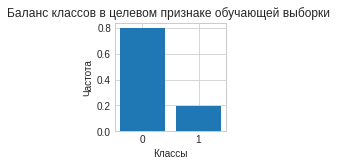

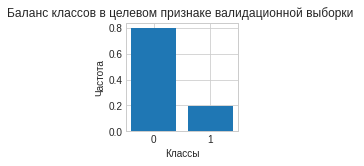

In [29]:
dict1 = {'обучающей':[target_train, 1],
         'валидационной' : [target_train, 2]}

for k, v in dict1.items():
    class_frequency = v[0].value_counts(normalize=True)
    plt.figure(figsize=(2,2))
    plt.bar(class_frequency.index, height = class_frequency)
    plt.title(f'Баланс классов в целевом признаке {k} выборки ')
    plt.xlabel('Классы')
    plt.ylabel('Частота')

* **Проанализируем частоты классов в результатах предсказаний модели случайного леса**

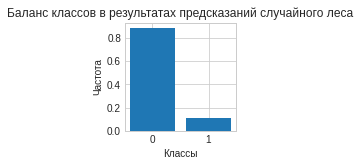

In [30]:
model = joblib.load('rfc.joblib')
model.fit(features_train, target_train)
predicted_valid = pd.Series(model.predict(features_valid))
class_frequency = predicted_valid.value_counts(normalize=True)

plt.figure(figsize=(2,2))
plt.bar(class_frequency.index, height = class_frequency)
plt.title(f'Баланс классов в результатах предсказаний случайного леса');
plt.xlabel('Классы')
plt.ylabel('Частота');

* **Изучим матрицу ошибок для модели случайного леса**

In [31]:
print(f'Матрица ошибок: \
      \n{confusion_matrix(target_valid, predicted_valid)}')

Матрица ошибок:       
[[1538   44]
 [ 230  188]]


**Вывод**: Проанализировав частоты классов целевого признака, определили, что классы 0 и 1 распределены в соотношении 80:20 соответственно.  Можно ожидать, что результаты предсказаний моделей будут склоняться к классу 0. Проверили нашу терию, выбранная нами модель в большинстве случаев выдает истинные ответы, однако ложноотрицательные ответы составляют около 10% всех ответов, т.е. модель чаще видит отрицательные ответы, там где их нет. Все это свидетельствует о дисбалансе классов.

## Борьба с дисбалансом

### Взвешивание классов

In [32]:
model = joblib.load('rfc.joblib')
model = model.set_params(class_weight = 'balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, predicted_valid):.3f} \
        \nAUC-ROC: {auc_roc:.3f}')

F1: 0.617         
AUC-ROC: 0.849


### Upsampling 

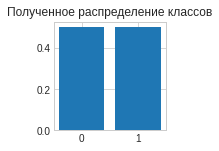

In [33]:
def upsample(features, target, repeat, class_to_upsample):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if class_to_upsample == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    elif class_to_upsample == 0:
        features_upsampled = pd.concat([features_zeros] * repeat + [features_ones])
        target_upsampled = pd.concat([target_zeros] * repeat + [target_ones])
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4, 1 )

class_frequency = target_upsampled.value_counts(normalize=True)
plt.figure(figsize=(2,2))
plt.bar(class_frequency.index, height = class_frequency)
plt.title('Полученное распределение классов');

**Decision tree**

In [34]:
parameters = {'max_depth': range (1,20, 2),
              'class_weight': ['balanced', None]}
dtr = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(dtr, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_upsampled, target_upsampled)

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.482        
AUC-ROC: 0.673        
Accuracy: 0.782        
Гиперпараметры: {'class_weight': None, 'max_depth': 19}


**Logistic Regression**

In [35]:
parameters = {'solver' : ['liblinear', 'lbfgs'],
              'class_weight': ['balanced', None]}
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
grid = HalvingGridSearchCV(lr, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_upsampled, target_upsampled)

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.490        
AUC-ROC: 0.764        
Accuracy: 0.702        
Гиперпараметры: {'class_weight': 'balanced', 'solver': 'liblinear'}


**Random Forest**

In [36]:
parameters = {'n_estimators': range (1, 110, 10),
              'max_depth': range (1,22, 2),
              'class_weight': ['balanced', None]}
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(rfc, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_upsampled, target_upsampled)
joblib.dump(grid.best_estimator_, 'rfc_upsampled.joblib')

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.604        
AUC-ROC: 0.840        
Accuracy: 0.850        
Гиперпараметры: {'class_weight': None, 'max_depth': 21, 'n_estimators': 101}


### Downsampling

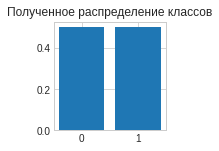

In [37]:
def downsample(features, target, fraction, class_to_downsample):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if class_to_downsample == 1:
        features_downsampled = pd.concat([features_zeros] + [features_ones.sample(frac=fraction, random_state=RANDOM_STATE)])
        target_downsampled = pd.concat([target_zeros] + [target_ones.sample(frac=fraction, random_state=RANDOM_STATE)])
    elif class_to_downsample == 0:
        features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [features_ones])
        target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=RANDOM_STATE)] + [target_ones])
        
    features_downsampled = shuffle(features_downsampled,random_state=RANDOM_STATE)
    target_downsampled = shuffle(target_downsampled, random_state=RANDOM_STATE)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25, 0)

class_frequency = target_downsampled.value_counts(normalize=True)
plt.figure(figsize=(2,2))
plt.bar(class_frequency.index, height = class_frequency)
plt.title('Полученное распределение классов');

**Decision tree**

In [38]:
parameters = {'max_depth': range (1,20, 2),
              'class_weight': ['balanced', None]}
dtr = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(dtr, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_downsampled, target_downsampled)

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.526        
AUC-ROC: 0.792        
Accuracy: 0.735        
Гиперпараметры: {'class_weight': 'balanced', 'max_depth': 7}


**Logistic Regression**

In [39]:
parameters = {'solver' : ['liblinear', 'lbfgs'],
              'class_weight': ['balanced', None]}
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
grid = HalvingGridSearchCV(lr, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_downsampled, target_downsampled)

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.484        
AUC-ROC: 0.762        
Accuracy: 0.701        
Гиперпараметры: {'class_weight': None, 'solver': 'liblinear'}


**Random Forest**

In [40]:
parameters = {'n_estimators': range (1, 110, 10),
              'max_depth': range (1,22, 2),
              'class_weight': ['balanced', None]}
rfc = RandomForestClassifier(random_state=RANDOM_STATE)
grid = HalvingGridSearchCV(rfc, parameters, random_state=RANDOM_STATE, scoring ='f1').fit(features_downsampled, target_downsampled)
joblib.dump(grid.best_estimator_, 'rfc_downsampled.joblib')

probabilities_valid = grid.best_estimator_.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print(f'F1: {f1_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nAUC-ROC: {auc_roc:.3f}  \
      \nAccuracy: {accuracy_score(target_valid, grid.best_estimator_.predict(features_valid)):.3f}  \
      \nГиперпараметры: {grid.best_params_}')

F1: 0.586        
AUC-ROC: 0.845        
Accuracy: 0.776        
Гиперпараметры: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 91}


**Вывод**: Были исследованы несколько способов борьбы с дисбаласном: взвешивание классов, upsampling и downsampling. Наилучшим способом оказалось взвешивание классов. Метрики моделей оказались лучше на сбалансированных этим методом данных.Наилучшей моделью оказалась модель `RandomForestClassifier`.

| Наилучшая модель |Способ борьбы с дисбалансом  | Гиперпараметры      |   F1-мера   |   ROC-AUC  |
| :---             |    :----:                   |          :---:      |        ---: |      ---:  |
| RandomForestClassifier | Взвешивание классов     | random_state=12345  |  **0.617**  | **0.849**  |
|                        |                       | class_weight = Balanced |             |            |
|                        |                       | max_depth = 9      |             |            |
|                        |                       | n_estimators = 51  |             |            |
     

## Тестирование модели

F1: 0.607
AUC-ROCK: 0.853


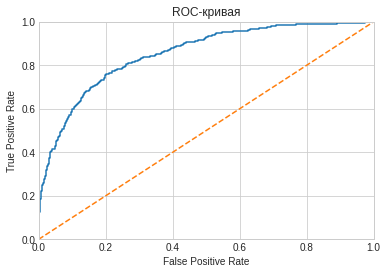

In [41]:
final_model = joblib.load('rfc.joblib')
final_model = model.set_params(class_weight = 'balanced')
final_model_prediction = final_model.predict(features_test)
print(f'F1: {f1_score(target_test, final_model_prediction):.3f}')

probabilities_valid = final_model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_valid )
print(f'AUC-ROCK: {auc_roc :.3F}')

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid) 

plt.figure()
plt.plot(fpr,tpr)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

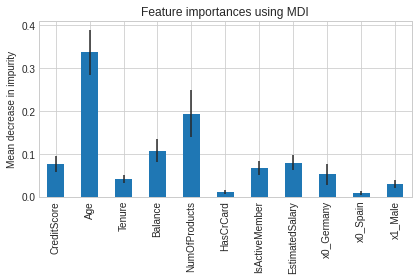

In [46]:
import numpy as np
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Вывод 

- В результате выполненной работы была проведеная предварительная обработка данных. В частности были заполнены пропуски методом k-ближайших соседей. Исходные данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 60:20:20. Далее было проведено кодирование категориальных признаков методом OHE и была произведена стандартизация количественных признаков. 
- Было исследовано 3 модели на несбалансированных данных: дерево решений, логистическая регрессия и случайный лес.
- Был выявлен дисбаланс классов, после чего был произведен взвешивание классов. В результате метрика F1 возросла с 0.58 до 0.62, а метрика AUC-ROC изменилась незначительно на валидационных данных. 
- Проверка модели на тестовой выборке показала метрику F1: 61%.